# Homework (Week 3) -- Biometrics (20 points)

In this homework we train Biometrics Verification model and use some features to increase quality:
1) Train ECAPA-TDNN (10 points)
2) Any contrastive loss (10 points)

Link to download dataset: https://disk.yandex.ru/d/lyhtieYbxQOYqw

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as torch_data
import torchaudio
import tqdm.notebook as tqdm
import urllib

import dataset

from IPython.display import clear_output

%matplotlib inline

In [2]:
# base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
# public_key = 'https://disk.yandex.ru/d/lyhtieYbxQOYqw'
# final_url = base_url + urllib.parse.urlencode(dict(public_key=public_key))
# response = requests.get(final_url)
# download_url = response.json()['href']
# !wget -O voxceleb.tar.gz "{download_url}"
# !tar -xf voxceleb.tar.gz

### Some model train example

In [3]:
DEVICE = 'cuda' # "cpu" for cpu, also you can use "cuda" for gpu and "mps" for apple silicon
DATADIR = '../data'
FEATS = 80
LOADER_WORKERS = 8

In [4]:
train_transform = nn.Sequential(
    torchaudio.transforms.MFCC(n_mfcc=FEATS),
    # torchaudio.transforms.TimeMasking(10),
    # torchaudio.transforms.FrequencyMasking(10),
)
test_transform = torchaudio.transforms.MFCC(n_mfcc=FEATS)
trainset = dataset.Dataset(os.path.join(DATADIR, 'voxceleb_train'), train_transform)
testset = dataset.Dataset(os.path.join(DATADIR, 'voxceleb_test'), test_transform)
test_targets = pd.read_csv(os.path.join(DATADIR, 'target.csv')).values.tolist()

c:\Users\andre\AppData\Local\Python\Python310\lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


### Models

In [5]:
# class Model(nn.Module):
#     def __init__(self, input_shape: int, output_shape: int, hidden: int, kernel: int = 7, sride: int = 2):
#         super().__init__()
#         self._emb = nn.Sequential(
#             nn.Conv1d(input_shape, hidden, kernel, stride=sride),
#             nn.ReLU(),
#             nn.Conv1d(hidden, hidden, kernel, stride=sride),
#             nn.ReLU(),
#             nn.Conv1d(hidden, hidden, kernel, stride=sride),
#             nn.AdaptiveMaxPool1d(1),
#         )
#         self._final = nn.Sequential(
#             nn.Linear(hidden, output_shape),
#             nn.LogSoftmax(dim=-1)
#         )

#     def forward(self, X) -> tuple[torch.Tensor, torch.Tensor]:
#         emb = self._emb(X).squeeze(2)
#         return self._final(emb), emb

### Metrics

Cosine similarity:
$CS(a, b) = \frac{<a, b>}{\|a\| \|b\|}$

In [6]:
def cosine_similarity(a, b):
    a = a.reshape(-1)
    b = b.reshape(-1)
    return np.dot(a, b) / np.linalg.norm(a) / np.linalg.norm(b)

Here is O(N log N) algorithm for find best_eer:
1) Sort prediction by probability
2) Going through items and recalculating far and frr

In [7]:
def best_eer(data):
    full = sorted(data, key=lambda x: (x[0], -x[1]))
    pos = len([item for item in full if item[1] == 1])
    neg = len(full) - pos
    cur_pos = pos
    cur_neg = 0
    best_eer = 1
    for _, label in full:
        if label == 1:
            cur_pos -= 1
        else:
            cur_neg += 1
        cur_eer = max((pos - cur_pos) / pos, (neg - cur_neg) / neg)
        best_eer = min(best_eer, cur_eer)
    return best_eer

### Train

In [8]:
def train_stage(model, opt, scheduler, batch_size: int = 32):
    loader = torch_data.DataLoader(
        trainset,
        shuffle=True,
        batch_size=batch_size,
        collate_fn=dataset.collate_fn,
        num_workers=LOADER_WORKERS,
    )
    loss_sum = 0.0
    batches = 0
    i = 0
    for X, Y, _ in tqdm.tqdm(loader):
        logits, _ = model.forward(X.to(DEVICE))
        loss = F.nll_loss(logits, Y.to(DEVICE))
        loss_sum += loss.item()
        batches += 1
        loss.backward()
        if (i + 1) % 4 == 0:
            opt.step()
            scheduler.step()
            opt.zero_grad()
        i += 1
    return loss_sum / batches

In [9]:
def calc_eval_score(model: nn.Module, batch_size: int = 32):
    loader = torch_data.DataLoader(
        testset,
        batch_size=batch_size,
        collate_fn=dataset.collate_fn,
        num_workers=LOADER_WORKERS,
    )
    items = {}
    target_scores = []
    with torch.no_grad():
        for X, _, pathes in tqdm.tqdm(loader):
            _, embds = model.forward(X.to(DEVICE))
            embds = embds.cpu().data.numpy().reshape(X.shape[0], -1)
            for embd, path in zip(embds, pathes):
                items[path] = embd
    for item1, item2, target in test_targets:
        item1 = item1.replace('/', '\\') # windows is cringe
        item2 = item2.replace('/', '\\') # windows is cringe x2
        target_scores.append((cosine_similarity(items[item1], items[item2]), target))
    return best_eer(target_scores)

In [10]:
def train(
    model: nn.Module,
    opt,
    scheduler,
    batch_size: int = 32,
    epochs: int = 12,
    train_fun = train_stage,
):
    train_losses = []
    eval_scores = []
    for epoch in range(epochs):
        model.train()
        train_losses.append(train_fun(model, opt, scheduler, batch_size=batch_size))
        
        model.eval()
        eval_scores.append(calc_eval_score(model, batch_size=batch_size))
        clear_output()
        fig, axis = plt.subplots(1, 2, figsize=(15, 7))
        axis[0].plot(np.arange(1, epoch + 2), train_losses, label='train CE loss')
        axis[0].set(xlabel='epoch', ylabel='CE Loss')
    
        axis[1].plot(np.arange(1, epoch + 2), eval_scores, label='eval')
        axis[1].set(xlabel='epoch', ylabel='EER')
        fig.legend()
        plt.show()
        print(f'Epoch {epoch + 1}. Train loss {train_losses[-1]}. Eval score {eval_scores[-1]}')

In [11]:
# model = Model(FEATS, trainset.speakers(), 128).to(DEVICE)
# opt = optim.Adam(model.parameters())
# train(model, opt)

### ECAPA TDNN (10 points)

Paper: https://arxiv.org/pdf/2005.07143.pdf

Papers for ECAPA parts:
- SE-Blocks - https://arxiv.org/pdf/1709.01507.pdf
- Res2Net - https://arxiv.org/pdf/1904.01169.pdf
- Attentive Stats Pooling - https://arxiv.org/pdf/1803.10963.pdf
- AAM Softmax - https://arxiv.org/pdf/1906.07317.pdf

Also you can optionally add other settings for paper:
- SpecAug
- Weight decay for optimizer
- LR scheduler

In [12]:
class SEBlock(nn.Module):
    def __init__(self, input_shape: int, reduction: int):
        super().__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Conv1d(input_shape, input_shape // reduction, 1),
            nn.ReLU(),
            nn.Conv1d(input_shape // reduction, input_shape, 1),
            nn.Sigmoid()
        )

    def __call__(self, X):
        return self.se(X) * X

In [13]:
b = SEBlock(128, 16)
X = torch.randn(10, 128, 10)
b(X).shape

torch.Size([10, 128, 10])

In [14]:
class Res2Net(nn.Module):
    def __init__(self, hidden: int, dilation: int, scale: int=8):
        super().__init__()
        assert hidden % scale == 0
        self.hidden = hidden
        self.scale = scale
        self.dconv3 = nn.ModuleList([
            nn.Sequential(
                nn.Conv1d(hidden // scale, hidden // scale, 3, dilation=dilation, padding='same'),
                nn.ReLU(),
                nn.BatchNorm1d(hidden // scale)
            ) for _ in range(scale)
        ])

    def __call__(self, X):
        split = torch.split(X, self.hidden // self.scale, dim=1)
        split = [conv(x) for conv, x in zip(self.dconv3, split)]
        out = torch.cat(split, dim=1)
        return out

In [15]:
b = Res2Net(128, 2)
X = torch.randn(10, 128, 10)
b(X).shape

torch.Size([10, 128, 10])

In [16]:
class EcapaBlock(nn.Module):
    def __init__(self, hidden: int, dilation: int, scale: int=8):
        super().__init__()
        assert hidden % scale == 0
        self.scale = scale
        self.conv1 = nn.Sequential(
            nn.Conv1d(hidden, hidden, 1),
            nn.ReLU(),
            nn.BatchNorm1d(hidden)
        )
        self.res2net = Res2Net(hidden, dilation, scale)
        self.conv1_2 = nn.Sequential(
            nn.Conv1d(hidden, hidden, 1),
            nn.ReLU(),
            nn.BatchNorm1d(hidden)
        )
        self.se = SEBlock(hidden, scale)

    def __call__(self, X):
        out = self.conv1(X)
        out = self.res2net(out)
        out = self.conv1_2(out)
        out = self.se(out)
        return out + X

In [17]:
b = EcapaBlock(128, 2)
x = torch.randn(10, 128, 10)
b(x).shape

torch.Size([10, 128, 10])

In [18]:
class AttentiveStatsPooling(nn.Module):
    def __init__(self, input_shape: int, hidden: int):
        super().__init__()
        self.attention = nn.Sequential(
            nn.Conv1d(input_shape * 3, hidden, 1),
            nn.Tanh(),
            nn.Conv1d(hidden, 1, 1),
            nn.Softmax(dim=-1)
        )

    def __call__(self, X):
        # X shape = [time, feats]
        # calc mean and std for X over time dimension
        # concatenate mean and std to X over feats dimension to make shape [time, feats * 3]
        # attention
        # weighted mean and std with weights from attention for original X
        
        means = X.mean(dim=-1, keepdim=True) * torch.ones_like(X)
        stds = X.std(dim=-1, keepdim=True) * torch.ones_like(X)
        features = torch.cat([means, stds, X], dim=-2)
        weights = self.attention(features)
        mean = (weights * X).sum(dim=-1, keepdim=True)
        std = ((weights * X * X).sum(dim=-1, keepdim=True) - mean * mean + 1e-5).sqrt()
        return torch.cat([mean, std], dim=-2).squeeze(-1)

In [19]:
b = AttentiveStatsPooling(12, 6)
x = torch.randn(10, 12, 10) * -10
b(x)

tensor([[-2.9578e+00,  1.0732e+00,  7.7118e-02,  8.1812e+00, -2.4408e+00,
         -1.8688e+00,  2.0225e-01, -1.6388e+00, -3.3137e+00,  1.3734e+00,
         -1.8709e+00, -3.4845e+00,  8.0985e+00,  5.7160e+00,  9.2962e+00,
          1.1901e+01,  8.3429e+00,  1.1244e+01,  6.5120e+00,  9.4882e+00,
          4.3649e+00,  4.9470e+00,  6.4368e+00,  1.6313e+01],
        [-6.9670e+00,  5.6571e+00,  4.4443e+00, -1.0113e+00,  5.1989e+00,
          2.4267e+00,  3.0852e-01,  2.7131e+00, -2.9435e+00, -2.2640e+00,
         -5.7678e+00,  1.9450e-01,  8.9762e+00,  7.6205e+00,  1.0326e+01,
          5.2978e+00,  1.5288e+01,  7.1388e+00,  6.2680e+00,  5.7554e+00,
          8.4746e+00,  1.2994e+01,  6.1922e+00,  5.7379e+00],
        [ 3.3037e+00,  1.2847e+00, -3.2133e+00, -4.3476e-01,  4.5245e+00,
          4.3421e+00, -2.0991e+00, -2.3484e+00, -3.7936e-01, -1.1262e+00,
          2.7448e+00, -2.9542e+00,  9.0230e+00,  7.1066e+00,  7.3835e+00,
          1.2978e+01,  7.7342e+00,  1.3057e+01,  9.7099e+00,  

In [20]:
class AAMSoftmax(nn.Module):
    def __init__(self, input_shape, n_class, margin, scale):
        super().__init__()
        self.emb = nn.Embedding(n_class, input_shape, max_norm=1)
        self.theta = nn.CosineSimilarity()
        self.margin = margin
        self.scale = scale

    def forward(self, X):
        # calc cosine similarity between X and weights
        # theta = angle from cosine similarity
        # return matrix S, where S_ij = 
        #     \log \frac{
        #         \exp{scale \cos{theta_ij + margin}}
        #     }{
        #         \exp{scale \cos{theta_ij + margin}} + \sum_{k != j} \exp{scale \cos{theta_ij}}
        #     }
        
        theta = torch.acos(self.theta(X.unsqueeze(2), self.emb.weight.T.unsqueeze(0)))
        S = torch.log(
            torch.exp(self.scale * torch.cos(theta + self.margin)) /
            (torch.exp(self.scale * torch.cos(theta + self.margin)) + torch.sum(torch.exp(self.scale * torch.cos(theta)), dim=1, keepdim=True) - torch.exp(self.scale * torch.cos(theta)))
        )
        return S

In [21]:
b = AAMSoftmax(128, 10, 0.2, 30)
x = torch.randn(10, 128)
b(x)

tensor([[ -6.9064, -11.2953, -15.4513, -11.9446,  -9.9523, -11.4955,  -5.4029,
          -9.1329, -15.7727, -12.9550],
        [-10.2275, -10.5897, -10.6963,  -9.5817,  -9.7981,  -8.3934,  -4.7720,
          -8.5557, -14.3054, -12.8248],
        [-10.9956, -11.4951,  -7.2352,  -9.0892,  -8.4487,  -9.4232,  -7.6129,
          -6.9180, -10.0141,  -7.5214],
        [-15.6993,  -9.5135,  -7.5460, -11.5781,  -7.1638,  -7.0914,  -7.6171,
          -9.3986,  -8.0241, -11.0667],
        [ -7.7943,  -6.5430, -11.8093,  -8.5987, -15.1884,  -9.4572,  -9.1581,
          -9.4745, -10.9658,  -6.7614],
        [ -9.0195, -11.1499, -16.3853,  -5.3143, -16.0193,  -6.9289, -12.5805,
         -11.8416, -15.2648, -13.3168],
        [-11.2371, -15.9041,  -9.2508, -12.0153, -10.1121,  -9.2004,  -8.0372,
          -4.7091, -15.1152, -11.3168],
        [ -2.7768, -10.1725, -15.1810, -12.4463, -10.5932, -15.0184, -12.0996,
         -13.4945, -11.1152, -11.9292],
        [-10.6778, -10.9429,  -9.2020,  -9.3291,

In [22]:
class EcapaTDNN(nn.Module):
    def __init__(self, input_shape: int, output_shape: int, hidden: int, embedding_shape: int):
        super().__init__()
        self.conv1 = nn.Conv1d(input_shape, hidden, 5, padding='same')
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm1d(hidden)
        self.block1 = EcapaBlock(hidden, 2)
        self.block2 = EcapaBlock(hidden, 3)
        self.block3 = EcapaBlock(hidden, 4)
        self.conv1_2 = nn.Sequential(
            nn.Conv1d(hidden * 3, hidden * 3, 1),
            nn.ReLU(),
        )
        self.pool = AttentiveStatsPooling(hidden * 3, hidden)
        self.bn1 = nn.BatchNorm1d(hidden * 6)
        self.fc = nn.Linear(hidden * 6, embedding_shape)
        self.bn2 = nn.BatchNorm1d(embedding_shape)
        self.aam_sm = AAMSoftmax(embedding_shape, output_shape, 0.2, 30)
            

    def forward(self, X):
        out = self.conv1(X)
        out = self.relu(out)
        out = self.bn(out)
        b1 = self.block1(out)
        b2 = self.block2(b1)
        b3 = self.block3(b2)
        out = self.conv1_2(torch.cat([b1, b2, b3], dim=1))
        out = self.pool(out)
        out = self.bn1(out)
        out = self.fc(out)
        out = self.bn2(out)
        return self.aam_sm(out), out

Train ECAPA model, at this point you can archive stable score (for several consecutive epochs) near 0.08 EER.

You can train ECAPA with hidden size 256 to increase speed

In [23]:
model = EcapaTDNN(FEATS, trainset.speakers(), 256, 256).to(DEVICE)
opt = optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CyclicLR(opt, base_lr=3e-4, max_lr=1e-1, mode="triangular2", step_size_up=1000)

In [24]:
num = 0
for param in model.parameters():
    num += param.numel() * 4
print(f"model weight: {num}, batch weight: {256 * 6 * 800 * 32 * 4}")

model weight: 10060164, batch weight: 157286400


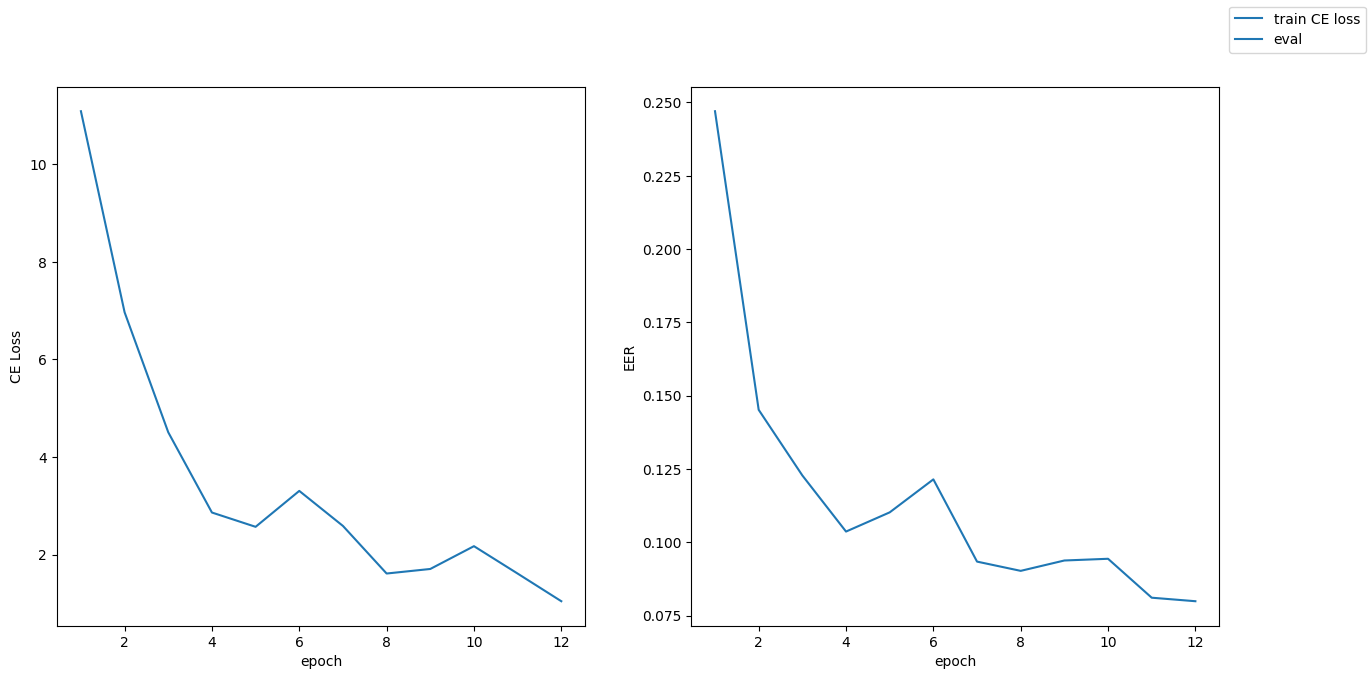

Epoch 12. Train loss 1.0459884024133317. Eval score 0.07987119585806289


In [25]:
train(model, opt, scheduler)

In [26]:
torch.save(model, 'model0.pt')

### Contrastive losses (10 points)

You can use anyone constrative loss.
Good article with contrastive losses https://lilianweng.github.io/posts/2021-05-31-contrastive/

Base losses:
- contrastive
- triplet -- it gives a better quality usually
- lifted structured loss -- better batch data utilization

The main problem with contrastive loss is the positive pairs sampler.
This is because a large number of classes provided only once per batch
in case of large number of classes in the dataset.

In [27]:
class PositivePairsSampler(torch.utils.data.Sampler):
    def __init__(self, speakers: list[int], batch_size: int):
        self.len = len(speakers) // batch_size // 2 * 2 * batch_size
        self.batch_size = batch_size
        idxs = torch.randperm(self.len // 2)
        self.pos = [x.item() for xs in zip(2 * idxs[::2], 2 * idxs[::2] + 1) for x in xs]
        self.rand = (2 * idxs[1::2]).tolist() + (2 * idxs[1::2] + 1).tolist()
        self.idx = []
        for i in range(len(self)):
            self.idx += self.pos[i * self.batch_size // 2: (i + 1) * self.batch_size // 2] + self.rand[i * self.batch_size // 2: (i + 1) * self.batch_size // 2]
        

    def __len__(self):
        return (self.len + self.batch_size - 1) // self.batch_size

    def __iter__(self):
        # yield __len__ batches as list of indexes of samples from dataset
        for batch in torch.chunk(torch.tensor(self.idx), len(self)):
            yield batch.tolist()
            

In [28]:
loader = torch_data.DataLoader(
        trainset,
        collate_fn=dataset.collate_fn,
        num_workers=LOADER_WORKERS,
        batch_sampler=PositivePairsSampler(trainset._speakers, 16)
    )
it = iter(loader)
for _ in range(3):
    _, Y, _ = next(it)
    print(Y)

tensor([ 502,  502,  333,  333,  957,  957, 1021, 1021,  104,  703,  783,   32,
         470,  100,  967, 1055])
tensor([ 186,  186,  801,  801,  159,  159,  965,  965,  367,  166,  131,  814,
          72, 1169,  752, 1074])
tensor([ 136,  136, 1064, 1064,  107,  107,  694,  694,  977,  159,  460,    2,
          20, 1052, 1184, 1094])


In [29]:
def contrastive_train_stage(model, opt, scheduler, batch_size: int = 32, lam = .2, eps = 1.5):
    # You can use any contrastive loss here to improve training
    # You can combine contrastive loss with the NLL loss after AAM softmax to improve stability
    loader = torch_data.DataLoader(
        trainset,
        collate_fn=dataset.collate_fn,
        num_workers=LOADER_WORKERS,
        batch_sampler=PositivePairsSampler(trainset._speakers, batch_size)
    )
    loss_sum = 0.0
    batches = 0
    i = 0
    for X, Y, _ in tqdm.tqdm(loader):
        logits, embeddings = model.forward(X.to(DEVICE))
        y = Y.to(DEVICE)
        loss1 = F.nll_loss(logits, y)
        pos = y[::2] == y[1::2]
        embeddings = embeddings / torch.linalg.vector_norm(embeddings, dim=-1).unsqueeze(-1)
        norm = torch.linalg.vector_norm(embeddings[::2] - embeddings[1::2], dim=-1)
        loss2 = (pos * norm + (~pos) * torch.max(torch.tensor(0), eps - norm)).mean()
        loss = loss1 + lam * loss2
        loss_sum += loss.item()
        batches += 1
        loss.backward()
        if (i + 1) % 4 == 0:
            opt.step()
            scheduler.step()
            opt.zero_grad()
        i += 1
    return loss_sum / batches
  

Train model with contrastive loss here. At this point you can archive EER near 0.06-0.07 (it should be at least on 0.005 to 0.01 better than before)

In [30]:
model = torch.load('model0.pt').to(DEVICE)
opt = optim.Adam(model.parameters(), lr = 2e-5, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CyclicLR(opt, base_lr=2e-5, max_lr=1e-2, mode="triangular2", step_size_up=1000)

C:\Users\andre\AppData\Local\Temp\ipykernel_16360\3995231155.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('model0.pt').to(DEVICE)


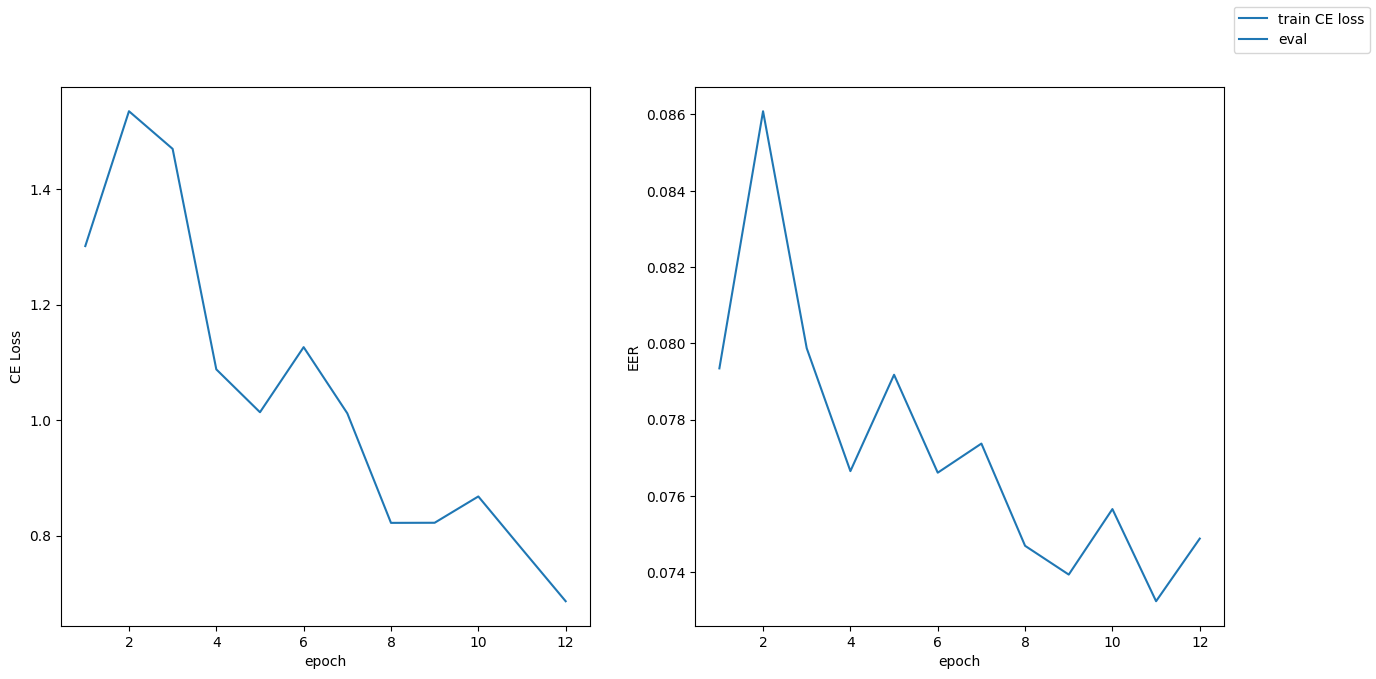

Epoch 12. Train loss 0.6864618084642322. Eval score 0.07488319232226291


In [31]:
train(model, opt, scheduler, train_fun=contrastive_train_stage)

In [32]:
torch.save(model, 'model1.pt')